In [1]:
import os, sys
import numpy as np

from pathlib import Path

from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack, join
from astropy.cosmology import FlatLambdaCDM
# from astropy.constants import c as c_speed
# from astropy import units as u

from scipy import interpolate
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

sys.path.append("./py")
from utils import *
# from utils import _get_rp_use_tag

sys.path.append("/Users/aberti/Desktop/research")
from plotutils import get_corners, fig_labels, get_colors

from params import BASEDIR, DATADIR, SIMDIR, H0, Om0
from params import get_boxsize, get_zsnap_data, get_sham_var_bins, get_abs_mag_lim, get_abs_mag_bins_clust

cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

import Corrfunc
from Corrfunc.theory.wp import wp as wp_corrfunc

#-- bins for clustering (data and mocks)
from params import nbins, rp_min, rp_max, rp_bins, rp_mids, bin_file


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:550: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-9.00 or later is installed on your system
  % gs_req)


In [2]:
s = "Dr ER see r to do DrSo by the do Dr Dr ft to ER e ER ER r to ER see ferry gt see r ya ER ft r ER RR ER ft to, tf tg see ft Dr53 free ft TR r RR GG to ER ft to g to TT eye ry TT to err Dr z ER see RR RR RR ER ft r RR TT TR ER r to try RR ER ft to err RR free by RR ER to see gt see TV free by RR y, TT free to, RR free ft r try RR zher to"

a = np.array(s.split(" "))

a.sort()



In [12]:
freq = np.array([len(a[a==i]) for i in np.unique(a)])

len(freq)


32

In [30]:
d = dict()

for i in range(len(np.unique(a))):
    d[np.unique(a)[i]]=freq[i]

d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}


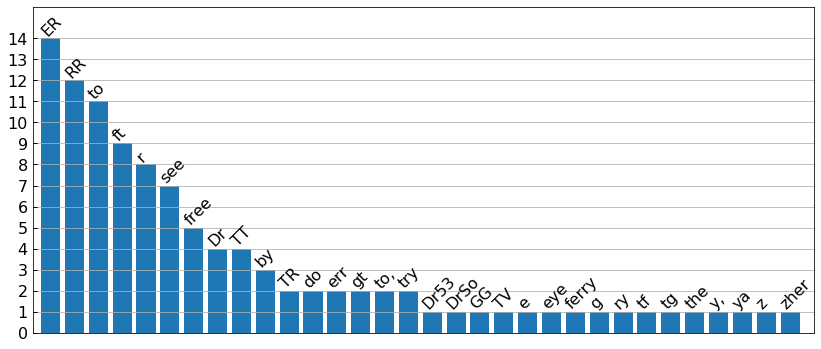

In [80]:
x = range(len(d))

fig, ax = plt.subplots(1,1,figsize=(14,6))

ax.bar(x, d.values())
ax.set_yticks(range(15))
plt.xticks([])#x, d.keys(), rotation=80)
ax.set_ylim(0,15.5)
ax.set_xlim(-0.75,32)
for i in range(len(d.keys())):
    ax.text(i-0.5, list(d.values())[i], list(d.keys())[i], rotation=45, verticalalignment="bottom", fontsize=16)

ax.grid(zorder=1)
plt.show()


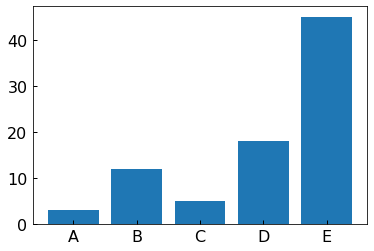

In [11]:
height = [3, 12, 5, 18, 45]
bars = ('A', 'B', 'C', 'D', 'E')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars)

plt.show()


In [23]:
a

array(['Dr', 'Dr', 'Dr', 'Dr', 'Dr53', 'DrSo', 'ER', 'ER', 'ER', 'ER',
       'ER', 'ER', 'ER', 'ER', 'ER', 'ER', 'ER', 'ER', 'ER', 'ER', 'GG',
       'RR', 'RR', 'RR', 'RR', 'RR', 'RR', 'RR', 'RR', 'RR', 'RR', 'RR',
       'RR', 'TR', 'TR', 'TT', 'TT', 'TT', 'TT', 'TV', 'by', 'by', 'by',
       'do', 'do', 'e', 'err', 'err', 'eye', 'ferry', 'free', 'free',
       'free', 'free', 'free', 'ft', 'ft', 'ft', 'ft', 'ft', 'ft', 'ft',
       'ft', 'ft', 'g', 'gt', 'gt', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'ry', 'see', 'see', 'see', 'see', 'see', 'see', 'see', 'tf',
       'tg', 'the', 'to', 'to', 'to', 'to', 'to', 'to', 'to', 'to', 'to',
       'to', 'to', 'to,', 'to,', 'try', 'try', 'y,', 'ya', 'z', 'zher'],
      dtype='<U5')

In [ ]:
#-- basic python

d = {"id":(1,1,2,1,4,2,2,4),"value":(0,4,1,3,0,4,1,2)}

sums = {}

for idx,id_tag in enumerate(d["id"]):
    if id_tag not in sums:
        sums[id_tag] = 0
    sums[id_tag] += d["value"][idx]

print(sums)


In [ ]:
#-- one (ugly) line with numpy and astropy.table

import numpy as np
from astropy.table import Table as tbl

sums = dict([ (id_tag, sum(tbl(d)["value"][tbl(d)["id"]==id_tag])) for id_tag in np.unique(tbl(d)["id"]) ])

print(sums)


In [ ]:
def _plot(this_band, this_zmin,
          sham_scatter_key   = "sham_tanh",
          los_scatter_key    = "los_lin4",
          N_chisq            = 1,
          DS                 = 1,
          n_iter             = 1,
          boxsize            = None,
          BASEDIR            = None,
          return_model_error = False,
          h                  = 0.7,
          d                  = "south",
          cross              = "GXG",
          quiet              = True,
          save               = True,
          rp_use_range       = (0.2,None),
          popt               = None,
         ):

    this_zmax = this_zmin + 0.1
    print(f"{this_band}\t({this_zmin:.1f},{this_zmax:.1f})\n")
    
    this_cat_tag = get_cat_tag(d,(this_zmin,this_zmin+0.1))
    if this_band=="MW1":
        this_abs_mag_lim_tag = get_MW1_tag( get_abs_mag_lim(this_zmin,"MW1") )
    elif this_band=="Mr":
        this_abs_mag_lim_tag = get_Mr_tag( get_abs_mag_lim(this_zmin,"Mr") )
    elif this_band=="Mz":
        this_abs_mag_lim_tag = get_Mz_tag( get_abs_mag_lim(this_zmin,"Mz") )
    else:
        raise Exception()

    #-- data
    wp_fname = f"{this_cat_tag}_{cross}_pimax{int(pimax)}.txt"
    fpath = f"{BASEDIR}/clustering/{zmag_tag}/{this_abs_mag_lim_tag}/no_abs_mag_bins/wp"
    if not os.path.exists(f"{fpath}/{wp_fname}"):
        fpath = f"{BASEDIR}/clustering/{zmag_tag}/v0.2/{this_abs_mag_lim_tag}/no_abs_mag_bins/wp"
        
    data = ascii.read(f"{fpath}/{wp_fname}")
    rp_cen = h*data["rp_cen"]
    wp     = h*data["wp"]
    wp_err = h*np.sqrt(data["wp_err"])

    rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{this_cat_tag}_{cross}.npy"
    cov = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_mids, pimax=pimax)
    cov_inv = np.linalg.inv(cov)
    
    kwargs_model_wp = dict(DS=DS, n_iter=n_iter, boxsize=boxsize, BASEDIR=BASEDIR, this_cat_tag=this_cat_tag, 
                           return_model_error=return_model_error, this_abs_mag_lim_tag=this_abs_mag_lim_tag,
                           popt=popt, N_chisq=N_chisq, rp_use_range=rp_use_range, quiet=quiet)
    models = {}
    this_scatter_tag = sham_scatter_key.replace("_","-")
    args   = (this_band, this_zmin, this_scatter_tag)
    wp_mod = _model_wp(*args, **kwargs_model_wp)
    models[this_scatter_tag] = wp_mod
        
    rp_use_tag, rp_use_label = get_rp_use_tag(rp_use_range, return_tag=True, return_label=True)
    print(rp_use_range, rp_use_tag, rp_use_label)
        
    rp_use_min, rp_use_max = rp_use_range
    if (rp_use_min != None) & (rp_use_max != None):
        rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
    elif (rp_use_min != None) & (rp_use_max==None):
        rp_use_idx = np.where(rp_cen > rp_use_min)[0]
    elif (rp_use_min==None) & (rp_use_max != None):
        rp_use_idx = np.where(rp_cen < rp_use_max)[0]
    else:
        rp_use_idx = np.arange(len(rp_cen))

    N_rp  = len(rp_use_idx)
    N_dof = 3 if "tanh" in this_scatter_tag else 2

    #-- make the figure
    fig, ax = plt.subplots(1, 1, figsize=(8,7))

    ax.set_xlim(0.02, 50)
    ax.set_ylim(20, 140)
    ax.tick_params(axis="both", which="major", labelsize=24)
    ax.set_xlabel(fig_labels["rp"], fontsize=24)
    ax.set_ylabel(fig_labels["rpwp"], fontsize=24)

    mag_label = r" $(M_{W1} <\ $" if (this_band=="MW1") else f" $(M_{this_band[1:]} <\ $"
    this_abs_mag_lim = get_abs_mag_lim(this_zmin, this_band)
    data_label = r"${\rm data}$" + mag_label + f"${this_abs_mag_lim})$"

    #-- plot data points
    ax.errorbar(rp_cen, rp_cen*wp, yerr=rp_cen*wp_err, label=data_label, marker="o", ms=5, color="k", linestyle="")

    #-- plot models
    colors = get_colors(3)
    lines  = ("-", "dashdot", "--", ":")
    
    for idx,k in enumerate(models.keys()):
        wp_mod = h*models[k]
        chisq  = np.sum([ [ (wp - wp_mod)[i]*cov_inv[i,j]*(wp - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])
        chisq_dof = chisq/(N_rp - N_dof)
        chisq_label = r"$\chi^2_{\nu}=\ $" + f"${int(chisq_dof)}$"
        model_label = r"${\rm model}$" + f" $(${rp_use_label}$;\ ${chisq_label}$)$"
        ax.plot(rp_cen, rp_cen*wp_mod, color=colors[idx], label=model_label, lw=2, ls=lines[idx])

    zphot_label = f"${this_zmin}\ $" + r"$ < z_{\rm phot} < $" + f"$\ {this_zmax}$"
    ax.text(get_corners(ax, logx=True, margin=0.05)["upper_left"][0], 110, zphot_label, ha="left", va="top", fontsize=24)
    # ax.text(*get_corners(ax, logx=True, margin=0.05)["upper_left"], zphot_label, ha="left", va="top", fontsize=24)

    ax.legend(fontsize=20, loc=2, handletextpad=0.5)
    ax.semilogx()
    if rp_use_min != None:
        ax.fill_between((ax.get_xlim()[0],rp_use_min), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
    if rp_use_max != None:
        ax.fill_between((rp_use_max,ax.get_xlim()[-1]), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)

    plt.tight_layout()

    fname = f"{BASEDIR}/figures/wp_model-vs-data_{this_cat_tag}_{this_abs_mag_lim_tag}_{this_scatter_tag}_{rp_use_tag}.png"
    if not save:x
        print(fname)
    elif save:
        print(f"Saving {fname}...")
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.1, dpi=200)

    plt.show()


<a class="anchor" id="outline"></a>

* [Model luminosity assignment](#sham)
* [Model color assignment](#color_assign)
* [Flag mock LRGs](#lrg_flag)


# Set parameters


In [ ]:
band        = "Mz"
zrange      = (0.5,0.6)
scatter_tag = "scatter-tanh-chisq1"

zmag_lim = 20.7
sim_tag  = "mdpl2"
sham_tag = "vpeak"
d        = "south"
pimax    = 150
h        = 0.7
# cross = "GXG"

#========== BEGIN HOUSEKEEPING ==========#
z_snaps, snap_nums, snaps = get_zsnap_data(sim_tag)

hist_idx = [len(snaps)-i for i in snap_nums]
vol_sim  = get_boxsize(sim_tag)**3
a_snaps = [snaps["scale"][snaps["snapnum"]==sn].data[0] for sn in snap_nums]

sham_var_bins, sham_var_cens = get_sham_var_bins(sham_tag)

zmin, zmax  = zrange
cat_tag     = get_cat_tag(d,zrange)
abs_mag_lim = get_abs_mag_lim(zmin, band)
zsim        = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
zsnap_tag   = get_zsnap_tag(zsim)
zmag_tag    = get_zmag_tag(zmag_lim)

MW1lim = get_abs_mag_lim(zmin,"MW1")
Mrlim  = get_abs_mag_lim(zmin,"Mr")
Mzlim  = get_abs_mag_lim(zmin,"Mz")
if band=="MW1":
    abs_mag_lim_tag = get_MW1_tag(MW1lim)
    abs_mag_range   = np.array((-24.5,-21.99))
    model_mag_range = np.array((-22.35,-25.35))
elif band=="Mr":
    abs_mag_lim_tag = get_Mr_tag(Mrlim)
    abs_mag_range   = np.array((-23,-20.49))
    model_mag_range = np.array((-21.6,-23.85))
elif band=="Mz":
    abs_mag_lim_tag = get_Mz_tag(Mzlim)
    abs_mag_range   = np.array((-23.75,-21.24))
    model_mag_range = np.array((-20.85,-24.6))
else:
    raise Exception()

abs_mag_ticks = np.arange(*abs_mag_range,0.5)

n_mag_bins_clust   = 4
abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band)

lf_name = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"
color_cdf_name = f"{BASEDIR}/data/stats/cdf_r-{band[1:]}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"

lum_func  = np.load(lf_name).item()
color_cdf = Table(np.load(color_cdf_name))

lum_func_full = np.load(f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_full.npy").item()
"""
V_zphot [N_gal]: volume corresponding to zphot for each galaxy in sample (N_gal total galaxies in sample)
V_eff   [N_gal]: effective volume for each galaxy in sample
abs_mag_bins [len(abs_mag_bins)]: absolute magnitude bins corresponding to ng_eff and gal_counts
ng_eff       [len(abs_mag_bins)]: (cumulative) effective galaxy number density as function of maximum absolute r- or W1-band magnitude 
gal_counts   [len(abs_mag_bins)]: (cumulative) galaxy number counts as function of maximum aboslute r- or W1-band magnitude
"""    
    
params = dict(abs_mag_bins_clust=abs_mag_bins_clust,
              abs_mag_bin_tags=abs_mag_bin_tags,
              abs_mag_lim=abs_mag_lim,
              abs_mag_lim_tag=abs_mag_lim_tag,
              abs_mag_range=abs_mag_range,
              abs_mag_ticks=abs_mag_ticks,
              a_snaps=a_snaps,
              band=band,
              bin_file=bin_file,
              cat_tag=cat_tag,
              color_cdf=color_cdf,
              d=d, # north, south
              h=h,
              hist_idx=hist_idx,
              # lum_func=lum_func,
              lum_func_full=lum_func_full,
              model_mag_range=model_mag_range,
              Mrlim=Mrlim,
              Mzlim=Mzlim,
              MW1lim=MW1lim,
              nbins=nbins,
              n_mag_bins_clust=n_mag_bins_clust,
              pimax=pimax,
              rp_bins=rp_bins,
              rp_max=rp_max,
              rp_mids=rp_mids,
              rp_min=rp_min,
              sham_tag=sham_tag,
              sham_var_bins=sham_var_bins,
              sham_var_cens=np.round(sham_var_cens,3),
              sim_tag=sim_tag,
              snap_nums=snap_nums,
              snaps=snaps,
              vol_sim=vol_sim,
              zmag_tag=zmag_tag,
              zmag_lim=zmag_lim,
              zmax=zmax,
              zmin=zmin,
              zrange=zrange,
              zsim=zsim,
              zsnap_tag=zsnap_tag,
              z_snaps=z_snaps,
             )

def param_list(values=False):
    for k in params.keys():
        ktype = str(type(params[k]))[8:-2]
        if values:
            if ktype in ("str","float","int","numpy.float64","numpy.ndarray","list","tuple","bool"):
                print(f"{k} ({ktype})\n{params[k]}\n")
            elif ktype=="dict":
                print(f"{k} ({ktype})\n{list(params[k].keys())}\n")
            elif "table" in ktype:
                print(f"{k} (table)\n{params[k].colnames}\n")
            else:
                print(f"{k} ({ktype})\n")
        else:
            print(f"{k}")
#=========== END HOUSEKEEPING ===========#


# print("snap\tz\tscale\n")
# for i,sn,z,a in zip(range(len(snap_nums)), snap_nums, z_snaps, a_snaps):
#     print("{}\t{:.5f}\t{:.5f}".format(sn,z,a))
#     if (i-1)%2==0:
#         print("")

# param_list(values=True)

In [ ]:
get_rp_use_tag(0.2, 20, return_label=True)


<a class="anchor" id="sham"></a>
# SHAM luminosity assignment

[BACK TO TOP](#outline)

### Load simulation snapshot

In [ ]:
# %%time

# #-- load simulation snapshot
# a     = snaps["scale"][snaps["redshift"]==zsim][0]
# scale = f"{a:.4f}"
# scale = scale.replace(".","p")

# quiet = False
# sham_tag_min = 125

# snap_fname = f"{SIMDIR}/{sim_tag}/CATALOGS/{sham_tag}min{int(sham_tag_min)}/a{scale}.npy"

# if os.path.exists( snap_fname ):
#     if not quiet:
#         print(f"Loading simulation shapshot (zsim = {zsim}; {sham_tag} > {sham_tag_min})...")
#     halocat = Table( np.load(snap_fname) )
    
# halocat.sort( sham_tag )

# halocat = halocat[::-1]


### Infer halo number densities from target luminosity function

In [ ]:
# %%time

# halocat = halocat[np.log10(halocat["parent_mvir"]) >= 11.5]
# sham_var = halocat[sham_tag]

# #-- get value of nh = nh( sham_var ) for each value of sham_var

# #-- halo number counts in bins of (log_)sham_var
# H,_ = np.histogram( np.log10(sham_var), bins=sham_var_bins )

# #-- halo abundance versus (min log_)sham_var
# cdf_log_sham_var = np.max(np.cumsum(H))-np.cumsum(H)

# #-- interpolation function for nh of (log_)sham_var
# nh_of_log_sham_var = interpolate.interp1d(sham_var_cens, np.array(cdf_log_sham_var)/vol_sim, fill_value="extrapolate")

# #-- inferred halo number densities for sham_var values
# nh_inferred = nh_of_log_sham_var( np.log10(sham_var) )

# cname = "nh_inferred"
# if cname in halocat.colnames:
#     halocat.remove_column( cname )
# halocat.add_column( Column(nh_inferred, name=cname) )


In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8,8))

# x = np.log10(halocat[sham_tag])[::1000]
# y = np.log10(halocat["nh_inferred"])[::1000]

# ax.scatter(x, y, s=1)

# ax.set_xlim(2.0,3.1)
# ax.set_ylim(-5.6,-1.5)

# ax.set_xlabel(r"log Vcirc")
# ax.set_ylabel(r"log halo number density (inferred)")

# plt.show()


### Assign luminosities *without* scatter based on inferred halo number density

In [ ]:
# %%time

# import scipy.stats as stats

# #-- get corresponding value of abs_mag for inferred nh values: abs_mag = abs_mag( ngal_eff=nh )
# abs_mag_bins = lum_func_full["abs_mag_bins"]
# ngal_eff     = lum_func_full["ng_eff"]

# #-- interpolation function for abs_mag of ngal_eff
# abs_mag_of_ngal_eff = interpolate.interp1d(ngal_eff, abs_mag_bins[::-1], fill_value="extrapolate")

# #-- mdoel magnitudes assigned according to nh_inferred WITHOUT any scatter implementation
# nh_inferred = halocat["nh_inferred"]
# abs_mag_inferred = abs_mag_of_ngal_eff( nh_inferred )

# #-- add inferred magnitudes (with MONOTONIC Vcirc correspondence) to halo catalog
# cname = f"{band}_no_scatter"
# if cname in halocat.colnames:
#     halocat.remove_column( cname )
# halocat.add_column( Column(abs_mag_inferred, name=cname) )

# halocat[f"{band}_no_scatter"][halocat[f"{band}_no_scatter"]==-np.inf] = np.inf
# # halocat = halocat[halocat[cname] > -np.inf]


## Apply linear and tanh mag-Vpeak scatter implementations


In [ ]:
# %%time

# #-- get linear and tanh fit scatter parameters for this zmin and band
# scatter_keys = np.array(list(popt_lin.keys()))
# scatter_keys_lin = scatter_keys[np.array([((band in i) & (str(zmin).replace('.','p') in i)) for i in scatter_keys])]

# scatter_keys = np.array(list(popt_tanh.keys()))
# scatter_keys_tanh = scatter_keys[np.array([((band in i) & (str(zmin).replace('.','p') in i)) for i in scatter_keys])]

# nsig_clip = 2.5

# for scatter_type in ("linear","tanh")[1:]:
#     if scatter_type=="linear":
#         these_scatter_keys = scatter_keys_lin
#     elif scatter_type=="tanh":
#         these_scatter_keys = scatter_keys_tanh
#     else:
#         raise Exception()

#     print(scatter_type.upper())    
#     print(these_scatter_keys)
#     for k in these_scatter_keys:
#         if scatter_type=="linear":
#             scatter_tag = f"scatter-lin-chisq{k[-1]}"
#             sigma_abs_mag_inferred = sig_lin(halocat[f"{band}_no_scatter"], *popt_lin[k])
#         elif scatter_type=="tanh":
#             scatter_tag = f"scatter-tanh-chisq{k[-1]}"
#             sigma_abs_mag_inferred = sig_tanh(halocat[f"{band}_no_scatter"], *popt_tanh[k])
#         else:
#             raise Exception()

#         #-- replace negative sigma values with zero if needed
#         sigma_abs_mag_inferred[np.where(sigma_abs_mag_inferred < 0)[0]] = 0

#         #-- add scatter to inferred magnitudes
#         abs_mag_inferred_scattered = stats.truncnorm.rvs(-nsig_clip, nsig_clip, halocat[f"{band}_no_scatter"], sigma_abs_mag_inferred)

#         #-- add inferred magnitudes (with SCATTERED Vcirc correspondence) to halo catalog
#         cname = f"{band}_scattered"
#         if cname in halocat.colnames:
#             halocat.remove_column( cname )
#         halocat.add_column( Column(abs_mag_inferred_scattered, name=cname) )

#         halocat.sort( f"{band}_scattered" )

#         abs_mag_inferred_sorted = halocat.copy()[f"{band}_no_scatter"]
#         abs_mag_inferred_sorted.sort()

#         if band in halocat.colnames:
#             halocat.remove_column( band )
#         halocat.add_column( Column(abs_mag_inferred_sorted, name=band) )

#         #-- sort catalog by model magnitude       
#         halocat.sort( band )

#         #-- add column for galaxy flag
#         c = "galaxy"
#         if c in halocat.colnames:
#             halocat.remove_column(c)
#         halocat.add_column(Column(np.zeros(len(halocat),dtype=bool), name=c))
#         #-- number of (sub)halos to select based on number density from data
#         Nhalo_select = int(np.max(lum_func["ng_eff"])*vol_sim)

#         #-- flag halos with galaxies
#         halocat["galaxy"][:Nhalo_select] = True

#         fname = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{zmag_tag}_{abs_mag_lim_tag}_{scatter_tag}.npy"
#         print(fname)

#         np.save(fname, halocat)
    

### Compute sigma array for mag-V$_{\rm circ}$ scatter

In [ ]:
# nsig_clip = 2.5

# k = list(popt_tanh.keys())
# print(k)
# sigma_abs_mag_inferred = sig_lin(halocat[f"{band}_no_scatter"], *popt_lin[ k ])

# #-- replace negative sigma values with zero if needed
# sigma_abs_mag_inferred[np.where(sigma_abs_mag_inferred < 0)[0]] = 0

# #-- add scatter to inferred magnitudes
# abs_mag_inferred_scattered = stats.truncnorm.rvs(-nsig_clip, nsig_clip, halocat[f"{band}_no_scatter"], sigma_abs_mag_inferred)


### Add magnitudes with *specified* scatter implementation to catalog

In [ ]:
# #-- add inferred magnitudes (with SCATTERED Vcirc correspondence) to halo catalog

# cname = f"{band}_scattered"
# if cname in halocat.colnames:
#     halocat.remove_column( cname )
# halocat.add_column( Column(abs_mag_inferred_scattered, name=cname) )


In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(8,8))

# ax.scatter(halocat[f"{band}_scattered"][::100], sigma_abs_mag_inferred[::100], s=1)
# ax.scatter(halocat[f"{band}_no_scatter"][::100], sigma_abs_mag_inferred[::100], s=1)

# plt.show()

In [ ]:
# %%time

# halocat.sort( f"{band}_scattered" )

# abs_mag_inferred_sorted = halocat.copy()[f"{band}_no_scatter"]
# abs_mag_inferred_sorted.sort()

# if band in halocat.colnames:
#     halocat.remove_column( band )
# halocat.add_column( Column(abs_mag_inferred_sorted, name=band) )


In [ ]:
# abs_mag_inferred           = halocat[f"{band}_no_scatter"]
# abs_mag_inferred_scattered = halocat[f"{band}_scattered"]
# abs_mag_final              = halocat[band]
# nh_inferred                = halocat["nh_inferred"]


# fig1, ax = plt.subplots(1, 1, figsize=(8,8))

# ax.scatter(nh_inferred[::100], abs_mag_inferred_scattered[::100], s=1, alpha=0.5)
# ax.scatter(nh_inferred[::1000], abs_mag_inferred[::1000], s=1)
# ax.set_xlabel(r"log halo number density (inferred)")
# ax.set_ylabel(r"abs mag inferred from Vcirc (with and without scatter)")
# #ax.set_xlim(-0.0002,0.004)
# ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


# fig2, ax = plt.subplots(1, 1, figsize=(8,8))

# ax.scatter(abs_mag_inferred[::100], abs_mag_inferred_scattered[::100], s=1, alpha=0.5)
# ax.set_xlabel("inferred mag NO scatter")
# ax.set_ylabel("inferred mag WITH scatter")
# ax.set_xlim(-23,-19.5)
# ax.set_ylim(-25,-17.5)


# fig3, ax = plt.subplots(1, 1, figsize=(8,8))

# ax.scatter(np.log10(halocat[sham_tag])[::100], abs_mag_inferred_scattered[::100], s=1, alpha=0.5)
# ax.scatter(np.log10(halocat[sham_tag])[::100], abs_mag_inferred[::100], s=1)

# ax.set_xlim(2.3,3.2)
# ax.set_ylim(-17.5,-25)

# ax.plot(ax.get_xlim(), abs_mag_lim*np.ones(2), ls="--", color="k")

# ax.set_xlabel(r"log Vcirc")
# ax.set_ylabel(r"inferred abs mag (with and without scatter)")

# plt.show()


### Flag (sub)halos with mock galaxies

In [ ]:
# #-- remove extra columns
# cols = (f"{band}_scattered", "nh_inferred", "galaxy")
# for c in cols:
#     if c in halocat.colnames:
#         halocat.remove_column(c)

# #-- sort catalog by model magnitude       
# halocat.sort( band )

# #-- add column for galaxy flag
# c = "galaxy"
# if c in halocat.colnames:
#     halocat.remove_column(c)
# halocat.add_column(Column(np.zeros(len(halocat),dtype=bool), name=c))

# #-- number of (sub)halos to select based on number density from data
# Nhalo_select = int(np.max(lum_func["ng_eff"])*vol_sim)

# #-- flag halos with galaxies
# halocat["galaxy"][:Nhalo_select] = True


### Save mock with magnitudes

In [ ]:
# %%time

# scatter_tag = f"scatter-lin-chisq{N_chisq}"
# scatter_tag

# # fname = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{zmag_tag}_{abs_mag_lim_tag}_{scatter_tag}.npy"
# # print(fname)

# # np.save(fname, halocat)


<a class="anchor" id="color_assign"></a>
# Model rest-frame color assignment (needs halo histories)

[BACK TO TOP](#outline)

<hr>

$${\rm \bf Starvation\ redshift}\ {\rm (Hearin\ et\ al. 2013, Saito\ et\ al. 2016)\!:}$$

$$z_{\rm starve} \equiv {\rm Max}\{z_{\rm char},z_{\rm acc},z_{\rm form}\} $$

${\rm \bf Characteristic\ redshift}\ \left(z_{\rm char}\right)\\
z_{\rm char} = {\rm Snapshot\ at\ which\ halo\ mass\ first\ exceeds}\ 10^{12}\ h^{-1}{\rm M}_\odot,\ {\rm or}\ z_{\rm obs}\ {\rm for\ (sub)halos\ that\ never\ achieve\ this\ mass}$

${\rm \bf Accretion\ redshift}\ \left(z_{\rm acc}\right)\\
z_{\rm acc} = 
\begin{cases}
z_{\rm obs}\ {\rm (for\ host\ halos)}\\
{\rm simulation\ snapshot\ at\ which\ subhalo\ accretes\ onto\ host\ halo}\ {\rm (for\ subhalos)}
\end{cases}$

${\rm \bf Formation\ redshift}\ \left(z_{\rm form}\right)\\
z_{\rm form} = {\rm redshift\ at\ which\ (sub)halo\ transitions\ from\ fast\ to\ slow\ accretion\ regime\!:}$
$$
\begin{align}
z_{\rm form} &= \frac{1}{a_{\rm form}} - 1,\ {\rm where}\ a_{\rm form}=\frac{4.1a_0}{c_{\rm vir}}\ {\rm and\ }{\rm(Wechsler\ et\ al. 2002,\ 2006)}\\
&= \frac{c_{\rm vir}}{4.1 a_0} - 1, {\rm where}\ c_{\rm vir}=\frac{R_{\rm vir}}{R_{\rm s}}\ {\rm at}
\begin{cases}
z_{\rm obs}\ {\rm (host\ halos)}\\
z_{\rm acc}\ {\rm (subhalos)}
\end{cases}\!,
R_{\rm s}\ {\rm is\ NFW\ profile\ scale\ radius}
\end{align}
$$

<hr>

### Load mock (mocks with histories on CHPC machines)

In [ ]:
# %%time

# #-- has magnitudes, colors, LRG flags, 
# fname = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{zmag_tag}_{abs_mag_lim_tag}_{scatter_tag}_galcat_LRG-flagged.npy"
# print(fname)

# cat = Table(np.load(fname))


In [ ]:
# # print(Nhalo_select)
# print(len(cat))
# print(len(cat[cat["LRG_IR"]==True]))
# print(len(cat[cat["LRG_opt"]==True]))

### Add placeholder columns for intermediate calculations


In [ ]:
# %%time

# for colname in ("zchar","zacc","zform"):
#     if colname in cat.colnames:
#         cat.remove_column(colname)
#     cat.add_column(Column(np.zeros(len(cat)), name=colname))


### Initialize counters for $z_{\rm starve}$ algorithm

In [ ]:
# DSprint = int(10e4)

# Mh_exceeds_12_yes = 0
# Mh_exceeds_12_no  = 0

# hist_len = len(cat["mvir_hist"][0])

# these_snaps     = snaps[:hist_len]
# these_scales    = these_snaps["scale"].data
# these_redshifts = these_snaps["redshift"].data
# this_scale      = these_snaps["scale"][-1]

# print(f"a_sim: {this_scale:.5f}")
# print(f"z_sim: {zsim}")


### Calculate $z_{\rm starve}$ and add to mock


In [ ]:
# %%time

# quiet = True

# for i in range(len(cat)):
#     htype = "Host Halo" if cat["upid"][i]==-1 else "Subhalo"
#     include = False
        
#     this_mvir_hist = cat["mvir_hist"][i]
#     this_rvir_hist = cat["rvir_hist"][i]
#     this_rs_hist   = cat["rs_hist"][i]
#     a_acc          = cat["acc_scale"][i]        

#     #-- z_char
#     mh_max = np.max(np.log10(this_mvir_hist))
#     if mh_max >= 12:
#         #include = True
#         Mh_exceeds_12_yes += 1
#         idx        = np.where(np.log10(this_mvir_hist) >= 12)[0][-1]
#         z_char_idx = hist_len-(idx+1)
#         z_char     = these_redshifts[z_char_idx]
#         if not quiet and (i%DSprint==0 or include):
#             print(f"\n========== {htype} {i} ==========")
#             print("idx\tlog Mh\tscale\tredshift")
#         for j in np.concatenate([[0],np.arange(np.max([1,idx-2]),np.min([hist_len-1,idx+3]))]):
#             z_char_idx = hist_len-(j+1)
#             mark="*" if j==idx else " "
#             if not quiet and (i%DSprint==0 or include):
#                 print(f"  {mark}{j}{mark}\t{round(np.log10(this_mvir_hist[j]),3)}\t{these_scales[z_char_idx]}\t{these_redshifts[z_char_idx]}")
#         if not quiet and (i%DSprint==0 or include):
#             print(f"z_char = {z_char}")
#     else:
#         Mh_exceeds_12_no += 1
#         z_char = zsim
#         if not quiet and i%DSprint==0:
#             print(f"max Mh = {round(mh_max,3)}")
#     if not quiet and i%DSprint==0:
#         print(f"z_char = {z_char}")
        
#     #-- z_acc and z_form
#     if cat["upid"][i] == -1: #-- host halos
#         z_acc = zsim
#         cvir  = (this_rvir_hist[0])/(this_rs_hist[0])
#     else: #-- subhalos
#         z_acc = 1/a_acc - 1
#         z_form_idx = np.where(a_acc==these_scales[::-1])[0][0]
#         if not quiet and (i%DSprint==0 or include):
#             print("\nidx\tscale\trvir\trs")
#             for j in np.arange(np.max([0,z_form_idx-2]),np.min([hist_len,z_form_idx+3])):
#                 mark="*" if j==z_form_idx else " "
#                 print(f"{mark}{j}{mark}\t{these_scales[::-1][j]}\t{this_rvir_hist[j]}\t{this_rs_hist[j]}")
#         cvir = this_rvir_hist[z_form_idx]/this_rs_hist[z_form_idx]
#         if not quiet and (i%DSprint==0 or include):
#             print(f"cvir at a_acc={a_acc}: {round(cvir,3)}")
#     z_form = np.round(cvir / (4.1*a_acc) - 1, 5)
#     if not quiet and (i%DSprint==0 or include):
#         print(f"z_form = {z_form}")
#         print(f"z_acc  = {z_acc:.4f}")

#     cat["zchar"][i] = z_char
#     cat["zacc"][i]  = z_acc
#     cat["zform"][i] = z_form

# print(f"\nHalos achieving 10^12 Msun/h:     {Mh_exceeds_12_yes}")
# print(f"Halos not achieving 10^12 Msun/h: {Mh_exceeds_12_no}")
# print(f"Correct total number of halos?    {Mh_exceeds_12_no+Mh_exceeds_12_yes==len(cat)}\n")

# z_starve = [np.max(i) for i in np.array([cat["zchar"],cat["zacc"],cat["zform"]]).T]

# if "zstarve" in cat.colnames:
#     cat.remove_column("zstarve")
# cat.add_column(Column(z_starve, name="zstarve"))


### Assign rest-frame colors based on $z_{\rm starve}$

In [ ]:
# zstarve_bins = np.arange(0,16.1,0.01)
# zstarve_cens = [np.mean(zstarve_bins[i:i+2]) for i in range(len(zstarve_bins)-1)]

# log_zstarve_bins = np.logspace(np.log10(0.1*np.floor(10*zsim)),np.log10(15),40)
# log_zstarve_cens = [np.log10(np.mean((10**log_zstarve_bins)[i:i+2])) for i in range(len(log_zstarve_bins)-1)]

# color_cdf_name = f"{BASEDIR}/data/stats/cdf_g-{band[1:]}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"
# color_cdf  = Table(np.load(color_cdf_name))
# color_cens = color_cdf["color_cens"]

# abs_mag_bins = [ -1*float(i.split("-")[0][1:].replace("p",".")) for i in color_cdf.colnames[1:] ]
# abs_mag_bins.append( -1*float(color_cdf.colnames[-1].split("-")[1][1:].replace("p",".")) )

# """
# #-- assign colors to halos based on MW1 bin and z_starve
# for each MW1 bin:
#     for each halo in this MW1 bin with given z_starve:
#     1) find y-axis position of CDF (between 0 and 1)
#     2) for this y-axis position, find corresponding point on color CDF
#     3) for this point on color CDF, find corresponding color and assign to this halo
# """
# color_cname = f"g-{band[1:]}"
# if color_cname in cat.colnames:
#     cat.remove_column(color_cname)
# cat.add_column(Column(np.zeros(len(cat)), name=color_cname))

# for i in range(len(abs_mag_bins)-1):
#     abs_mag_min, abs_mag_max = abs_mag_bins[i:i+2]

#     abs_mag_bin_label = "n{:.2f}-n{:.2f}".format(np.abs(abs_mag_min), np.abs(abs_mag_max))
#     abs_mag_bin_label = abs_mag_bin_label.replace(".","p")

#     this_bin_color_cdf = color_cdf[abs_mag_bin_label]

#     abs_mag_assigned = cat[f"{band}"]
#     z_starve = cat["zstarve"]
    
#     abs_mag_mask = (abs_mag_assigned < abs_mag_min) & (abs_mag_assigned >= abs_mag_max)
    
#     this_bin_zstarve = z_starve[abs_mag_mask]
#     H,_ = np.histogram(this_bin_zstarve, bins=log_zstarve_bins)
#     this_bin_zstarve_cdf = np.cumsum(H)/np.cumsum(H)[-1]

#     #-- interpolated halo CDF position as function of z_starve
#     #-- input: z_starve
#     #-- infer: halo CDF position
#     halo_cdf_of_zstarve = interpolate.interp1d(log_zstarve_cens, this_bin_zstarve_cdf, fill_value="extrapolate")

#     #-- interpolated g-r color as function of g-r CDF position
#     #-- input: color CDF position
#     #-- infer: color
#     color_of_color_cdf = interpolate.interp1d(this_bin_color_cdf, color_cens, fill_value="extrapolate")

#     #-- inferred halo CDF position for given z_starve
#     halo_cdf_inferred = halo_cdf_of_zstarve(this_bin_zstarve)

#     #-- assigned (inferred) color for given color CDF position
#     halo_color_inferred = color_of_color_cdf(halo_cdf_inferred)

#     cat[f"g-{band[1:]}"][abs_mag_mask] = halo_color_inferred

# colors = cat[f"g-{band[1:]}"]

<a class="anchor" id="lrg_flag"></a>
# Flag optical and IR mock LRGs

[BACK TO TOP](#outline)

### Load LRG data

In [ ]:
# %%time

# fname = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{zmag_tag}_{abs_mag_lim_tag}_lin-scatter_LRG-flagged.npy"
# print(fname)

# # np.save(fname, cat)

# cat = Table(np.load(fname))
    

In [ ]:
# """
# H_(lrg/full)[color_idx,mag_idx]

# color_edges: 0 => smallest;      -1 => largest
# mag-edges:   0 => most negative; -1 => least negative
# """

# lrgfrac_opt_fname = f"{BASEDIR}/data/stats/lrgfrac_optical-select_{band[1:]}-band_{cat_tag}.npy"
# print(lrgfrac_opt_fname)
# lrgfrac_opt = np.load(lrgfrac_opt_fname, allow_pickle=True)

# lrgfrac_IR_fname = f"{BASEDIR}/data/stats/lrgfrac_IR-select_{band[1:]}-band_{cat_tag}.npy"
# print(lrgfrac_IR_fname)
# lrgfrac_IR = np.load(lrgfrac_IR_fname, allow_pickle=True)


In [ ]:
# mag_bins_opt, color_bins_opt, H_lrg_opt, H_full_opt = lrgfrac_opt
# mag_bins_IR, color_bins_IR, H_lrg_IR, H_full_IR = lrgfrac_IR


In [ ]:
# np.sum(H_full_opt)

In [ ]:
# np.sum(H_full_IR)

### Process LRG data for application to mocks

In [ ]:
# %%time

# for c in ("LRG_IR", "LRG_opt"):
#     if c in cat.colnames:
#         cat.remove_column(c)
#     cat.add_column(Column(np.zeros(len(cat), dtype=bool), name=c))

# model_mags = cat[band]
# model_mag_min = np.min(model_mags)
# model_mag_max = np.max(model_mags)

# model_colors = cat[f"g-{band[1:]}"]
# model_color_min = np.min(model_colors)
# model_color_max = np.max(model_colors)

# ### OPTICAL SELECTION ###
# mag_bins_opt, color_bins_opt, H_lrg_opt, H_full_opt = lrgfrac_opt

# if model_mag_min < np.min(mag_bins_opt):
#     mag_bins_opt[0] = np.floor(model_mag_min)
# if model_mag_max > np.max(mag_bins_opt):
#     mag_bins_opt[-1] = model_mag_max

# if model_color_min < np.min(color_bins_opt):
#     color_bins_opt[0] = np.floor(model_color_min)
# if model_color_max > np.max(color_bins_opt):
#     color_bins_opt[-1] = model_color_max

# lrg_frac_opt = H_lrg_opt/H_full_opt

# #print(mag_bins_opt)

# ### IR SELECTION ###
# mag_bins_IR, color_bins_IR, H_lrg_IR, H_full_IR = lrgfrac_IR

# if model_mag_min < np.min(mag_bins_IR):
#     mag_bins_IR[0] = np.floor(model_mag_min)
# if model_mag_max > np.max(mag_bins_IR):
#     mag_bins_IR[-1] = model_mag_max

# if model_color_min < np.min(color_bins_IR):
#     color_bins_IR[0] = np.floor(model_color_min)
# if model_color_max > np.max(color_bins_IR):
#     color_bins_IR[-1] = model_color_max

# lrg_frac_IR = H_lrg_IR/H_full_IR

# #print(mag_bins_IR)


### Flag IR mock LRGs

In [ ]:
# %%time

# ### IR SELECTION ###

# N_bins = (len(color_bins_IR)-1)*(len(mag_bins_IR)-1)

# k = 1
# cat["LRG_IR"] = False

# for i in range(len(color_bins_IR)-1):
#     color_mask = (model_colors > color_bins_IR[i]) & (model_colors <= color_bins_IR[i+1])
#     for j in range(len(mag_bins_IR)-1):
#         mag_mask = (model_mags > mag_bins_IR[j]) & (model_mags <= mag_bins_IR[j+1])
#         bin_mask = mag_mask & color_mask
#         N_mock   = len(cat[bin_mask])
#         if N_mock > 0:
#             indices = np.where(bin_mask)[0]            
#             N_gal_IR = H_full_IR[i,j]
#             N_lrg_IR = H_lrg_IR[i,j]
            
#             targ_lrg_IR = 0
#             if (N_lrg_IR > 0) & (N_gal_IR > 0):
#                 targ_lrg_IR = int(N_mock*lrg_frac_IR[i,j])

#             if (targ_lrg_IR > 0):
#                 if (targ_lrg_IR < N_mock):
#                     selected = indices[np.random.choice(len(indices), targ_lrg_IR, replace=False)]
#                     cat["LRG_IR"][selected] = True
#                 else:
#                     cat["LRG_IR"][indices] = True

#             if (targ_lrg_IR > 0) and (k%100==0):
#                 print(f"{k}/{N_bins}\t{color_bins_IR[i]:.2f}\t{mag_bins_IR[j]:.2f}\t{N_mock}\t{targ_lrg_IR}")
#         k += 1
        

### Flag optical mock LRGs

In [ ]:
# %%time

# ### OPTICAL SELECTION ###

# N_bins = (len(color_bins_opt)-1)*(len(mag_bins_opt)-1)

# k = 1
# cat["LRG_opt"] = False

# for i in range(len(color_bins_opt)-1):
#     color_mask = (model_colors > color_bins_opt[i]) & (model_colors <= color_bins_opt[i+1])
#     for j in range(len(mag_bins_opt)-1):
#         mag_mask = (model_mags > mag_bins_opt[j]) & (model_mags <= mag_bins_opt[j+1])
#         bin_mask = mag_mask & color_mask
#         N_mock   = len(cat[bin_mask])
#         if N_mock > 0:
#             indices = np.where(bin_mask)[0]            
#             N_gal_opt = H_full_opt[i,j]
#             N_lrg_opt = H_lrg_opt[i,j]
            
#             targ_lrg_opt = 0
#             if (N_lrg_opt > 0) & (N_gal_opt > 0):
#                 targ_lrg_opt = int(N_mock*lrg_frac_opt[i,j])

#             if (targ_lrg_opt > 0):
#                 if (targ_lrg_opt < N_mock):
#                     selected = indices[np.random.choice(len(indices), targ_lrg_opt, replace=False)]
#                     cat["LRG_opt"][selected] = True
#                 else:
#                     cat["LRG_opt"][indices] = True

#             if (targ_lrg_opt > 0) and (k%100==0):
#                 print(f"{k}/{N_bins}\t{color_bins_opt[i]:.2f}\t{mag_bins_opt[j]:.2f}\t{N_mock}\t{targ_lrg_opt}")
#         k += 1
        

In [ ]:
# %%time

# ### OPTICAL SELECTION ###

# out = []
# k = 1

# for i in range(len(color_bins_opt)-1):
#     color_mask = (model_colors > color_bins_opt[i]) & (model_colors <= color_bins_opt[i+1])
#     for j in range(len(mag_bins_opt)-1):
#         mag_mask = (model_mags > mag_bins_opt[j]) & (model_mags <= mag_bins_opt[j+1])
#         bin_mask = mag_mask & color_mask
#         this_bin = cat[bin_mask]
#         N_mock   = len(this_bin)

#         N_gal_opt = H_full_opt[i,j]
#         N_lrg_opt = H_lrg_opt[i,j]
#         targ_lrg_opt = 0
#         if (N_lrg_opt > 0) & (N_gal_opt > 0):
#             targ_lrg_opt = int(N_mock*lrg_frac_opt[i,j])
        
#         if (targ_lrg_opt > 0):
#             if (targ_lrg_opt < N_mock):
#                 rand = np.random.choice(N_mock, targ_lrg_opt, replace=False)
#                 this_bin["LRG_opt"][rand] = 1
#             else:
#                 this_bin["LRG_opt"] = 1
        
#         out.append(this_bin)

#         if k%100==0:
#             print(f"{k}/{(len(color_bins_opt)-1)*(len(mag_bins_opt)-1)}\t{color_bins_opt[i]:.2f}\t{mag_bins_opt[j]:.2f}\t{N_mock}\t{targ_lrg_opt}")
#         k += 1

# out = Table(np.concatenate(out))

# names = ("halo_id","LRG_opt")
# out   = Table(data=(out["halo_id"],out["LRG_opt"]), names=names)

# cat = join(cat, out, join_type="outer", keys="halo_id")

# cat.remove_column("LRG_opt_1")
# cat.rename_column("LRG_opt_2", "LRG_opt")


<a class="anchor" id="sandbox"></a>
# SANDBOX

[BACK TO TOP](#outline)